# Solution to Houses Price
## Diego 

In [1]:
#%matplotlib inline
# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder


## Loading the data

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

## First view of the data

In [ ]:
train.head(10)

## Search for null, NaN values

In [5]:
print train.info()
print test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Not used features:
- "MiscFeature"
- "Fence" 
- "PoolQC"
- "FireplaceQu"
- "Alley"

## Rest of features have a relative small quantity of NaNs
### The following features have almost all the values without Nans:
1. MSZoning
2. LotFrontage
3. Utilities
4. Exterior1st
5. Exterior2st
6. MasVnrType
7. MasVnrArea
8. BsmtQual
10. BsmtCond
11. BsmtExposure
12. BsmtFinType 
13. BsmtFinSF1
14. BsmtFinSF2
15. BsmtFinType2
16. BsmtUnfSF
17. TotalBsmtSF
18. BsmtFullBath
19. BsmtHalfBath
20. KitchenQual
21. Functional
22. GarageType
23. GarageYrBlt
24. GarageFinish
25. GarageCars
26. GarageArea
27. GarageQual
28. GarageCond
29. SaleType
#### Then we will add missing values at first with mode for categorical features and with the mean for numerical ones.

### Let's see the distribution of SalePrice

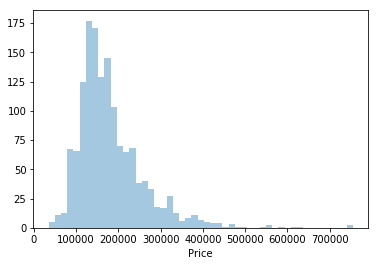

In [6]:
sns.distplot(train["SalePrice"].dropna().values, kde=False,axlabel="Price")
plt.show()


## Correlation between numerical features

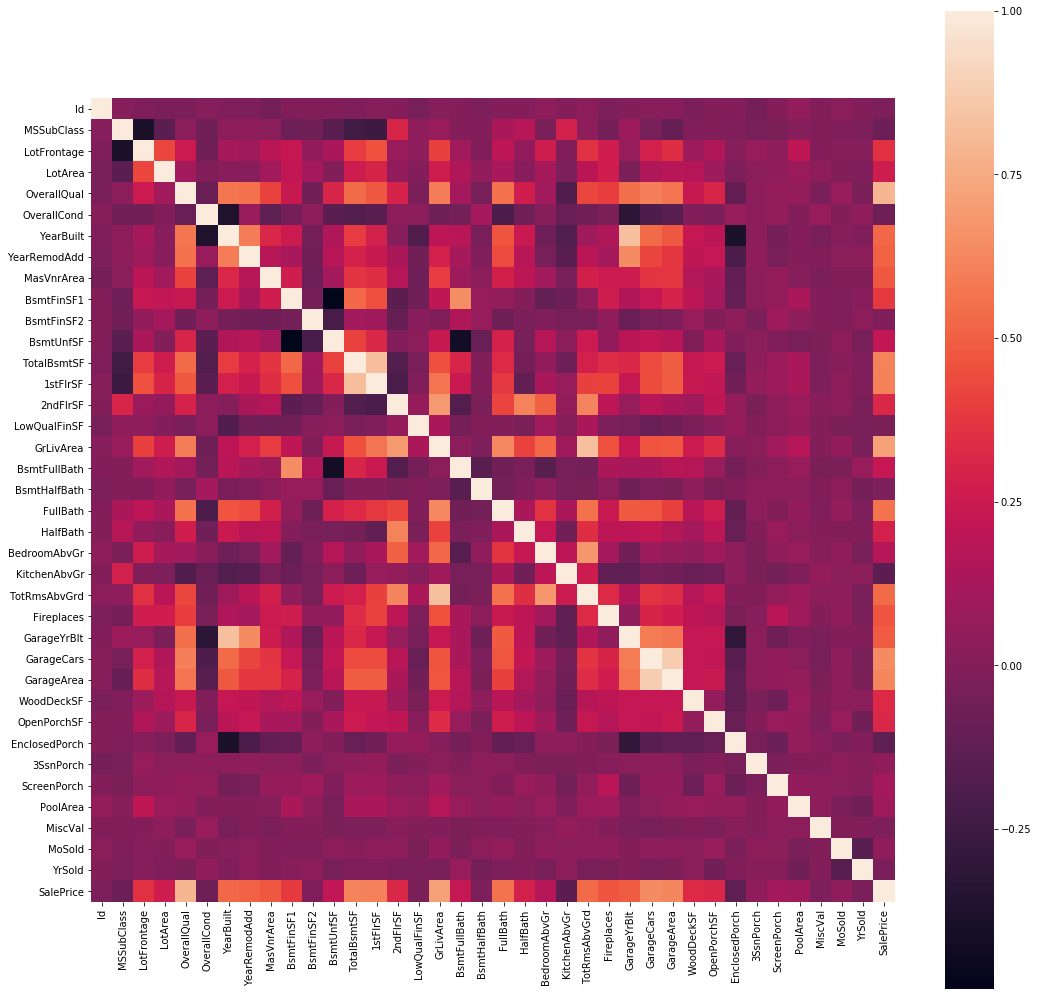

In [7]:
plt.figure(figsize=(18,18))
sns.heatmap(train.drop(["MiscFeature","Fence","PoolQC","FireplaceQu","Alley"],axis=1).corr(), square=True)
plt.show()

## Let's use only features that have at least some minimal correlation with final price (SalePrice)
Now that we can see how the features correlate let's check the correlations with SalePrice

In [8]:
correlation=train.corr()
correlation_with_target=correlation[["SalePrice"]].drop("SalePrice",axis=0)
numerical_feaures=correlation_with_target.sort_values(by="SalePrice",ascending=False)
numerical_feaures_noincluded=numerical_feaures.loc[numerical_feaures["SalePrice"]<0.05]
numerical_feaures_noincluded=list(numerical_feaures_noincluded.axes[0])

## Let's do some plots for the categorical values

In [9]:
train_new=train.drop(["MiscFeature","Fence","PoolQC","FireplaceQu","Alley"],axis=1)

In [10]:
cols=train_new.columns
num_cols=train_new._get_numeric_data().columns
categorical_columns=list(set(cols)-set(num_cols))
#cateogircal_with_nan=list(set(categorical_columns).intersection(columns_with_nan))

In [11]:
def plot_things(feature):
    plt.figure(figsize=(10,10))

    #sns.barplot(x=feature,y="SalePrice", hue="OverallQual",data=train_new)
    sns.barplot(x=feature,y="SalePrice",data=train_new)
    plt.show()
    plt.figure(figsize=(10,10))

    sns.countplot(x=feature,data=train_new)
    plt.show()


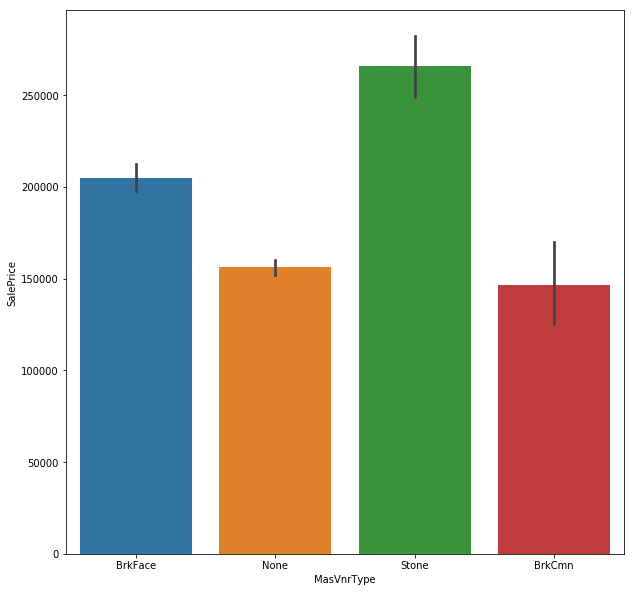

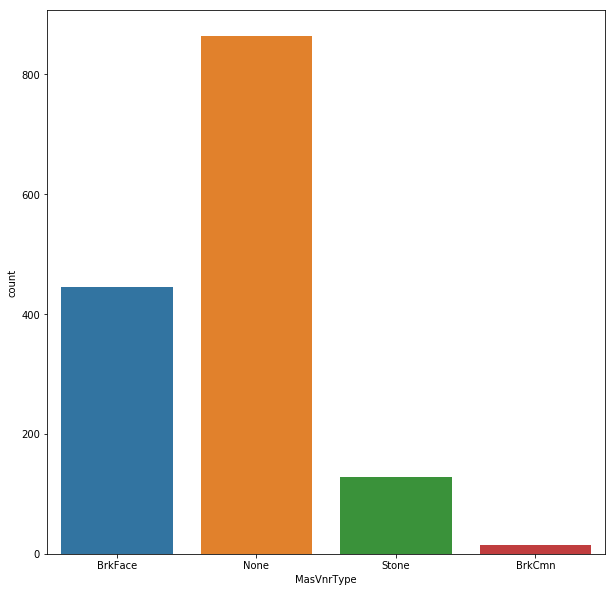

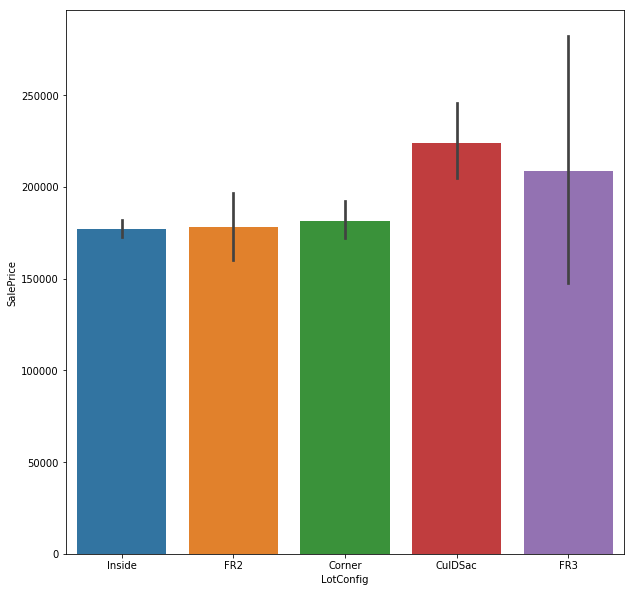

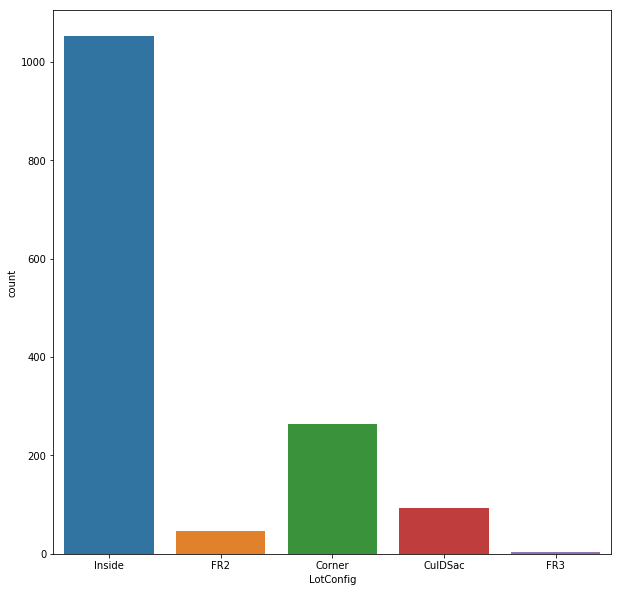

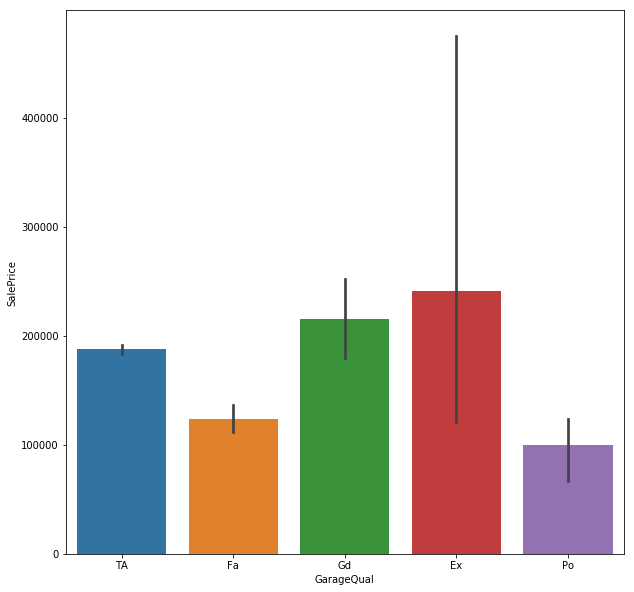

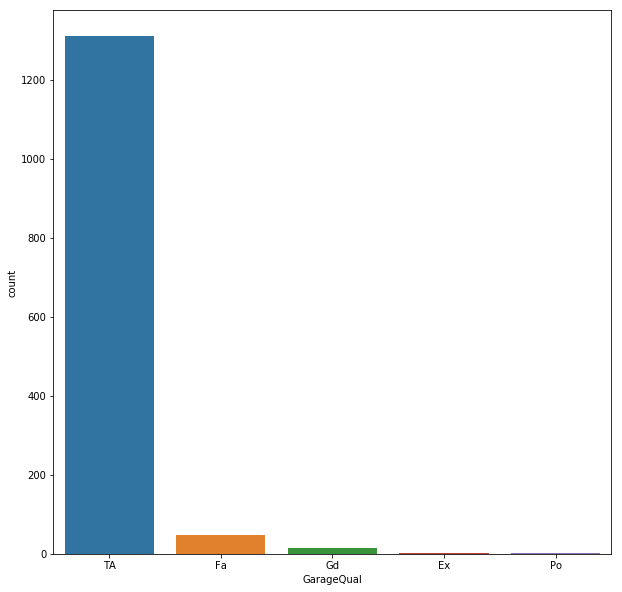

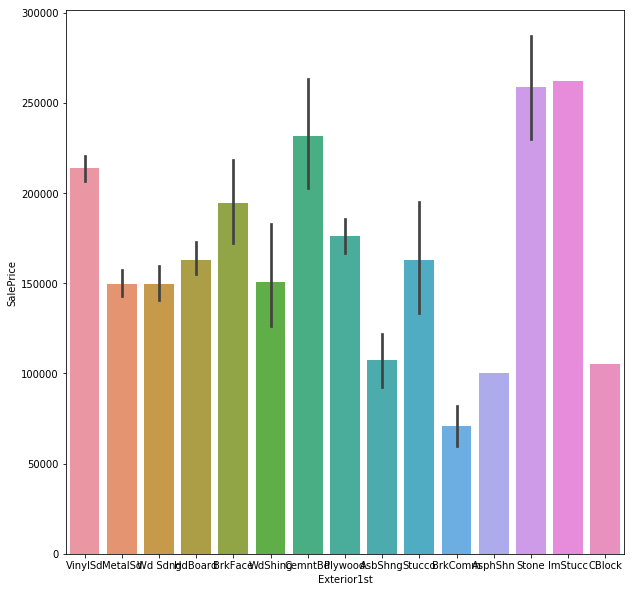

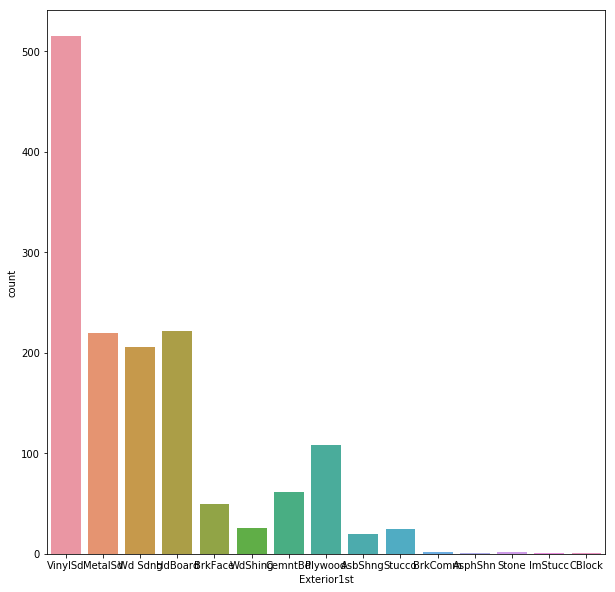

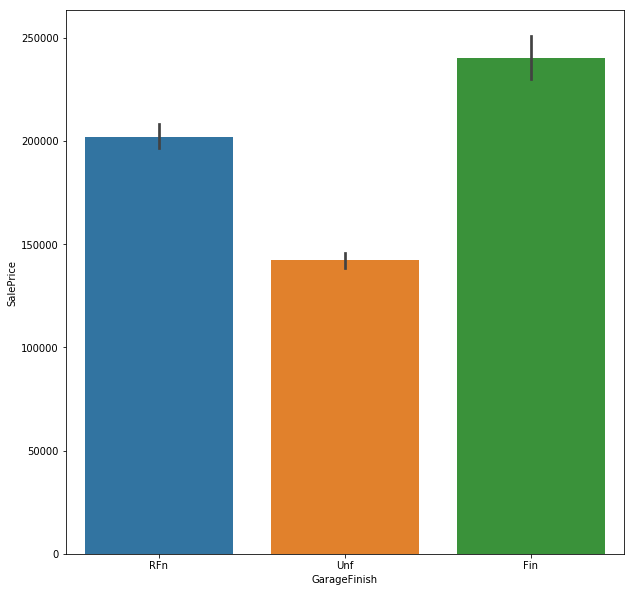

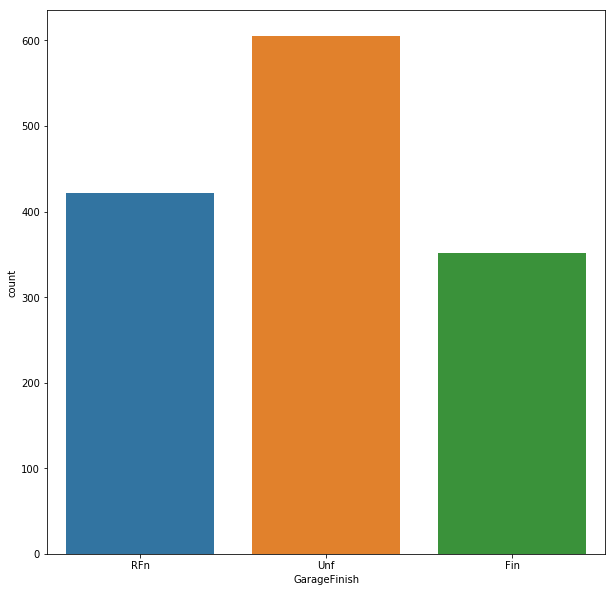

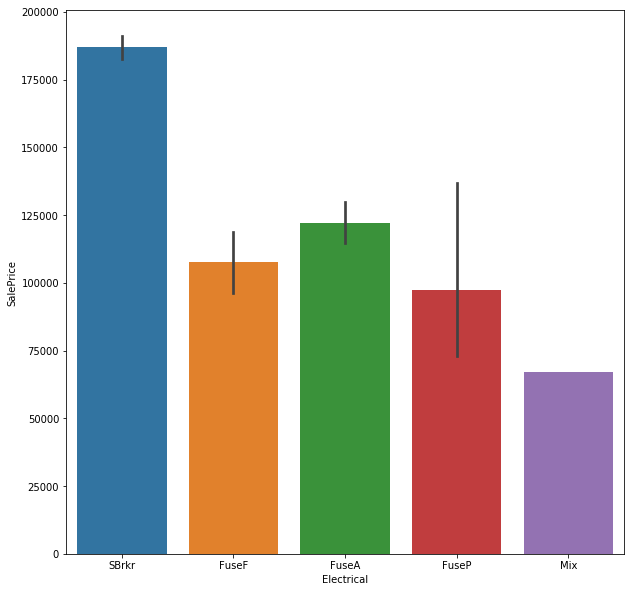

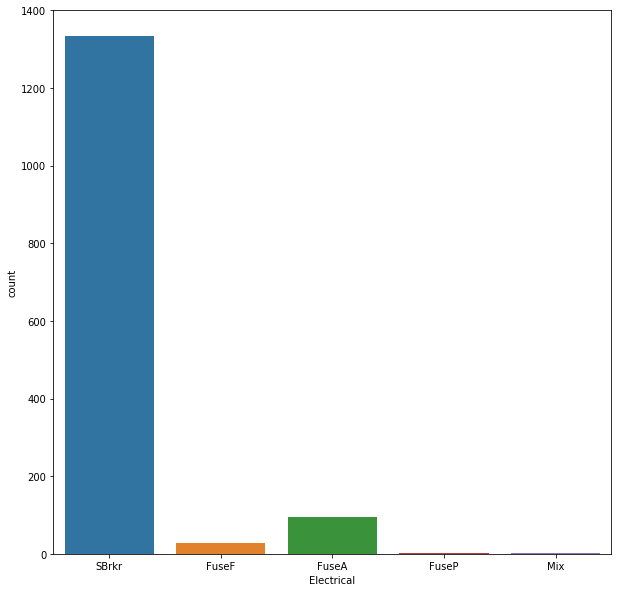

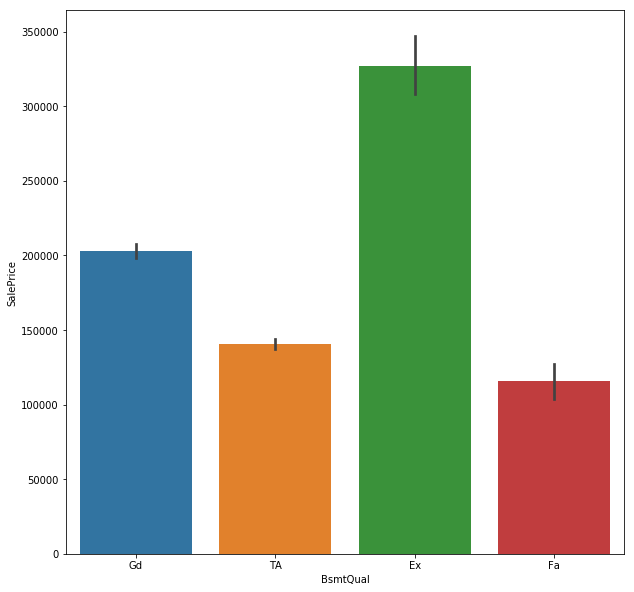

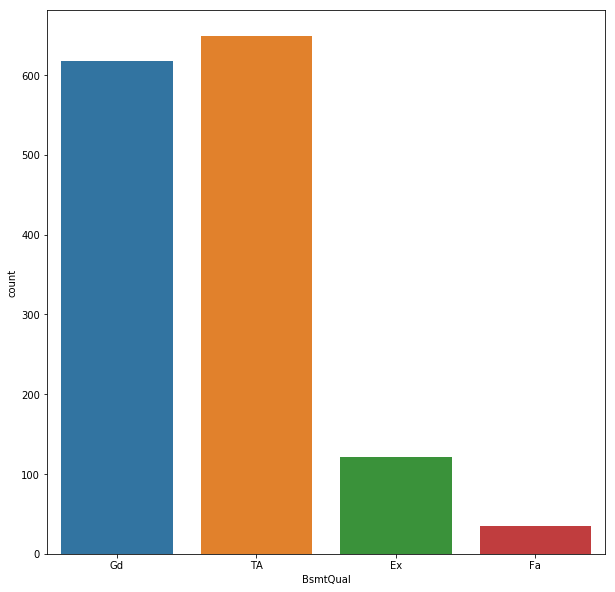

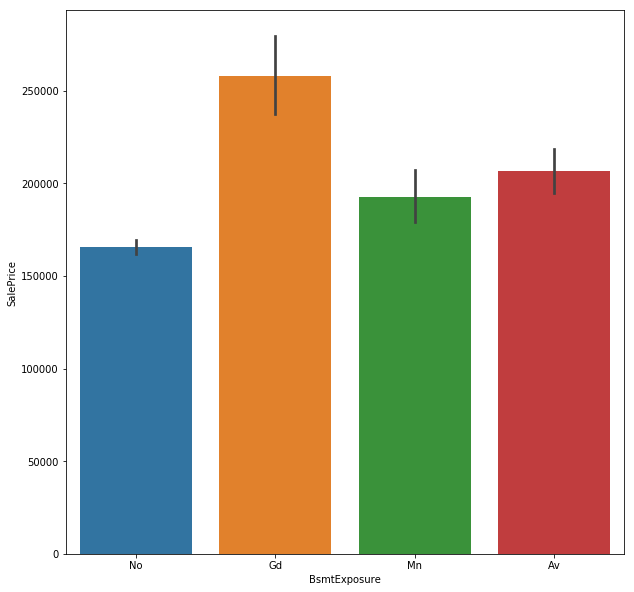

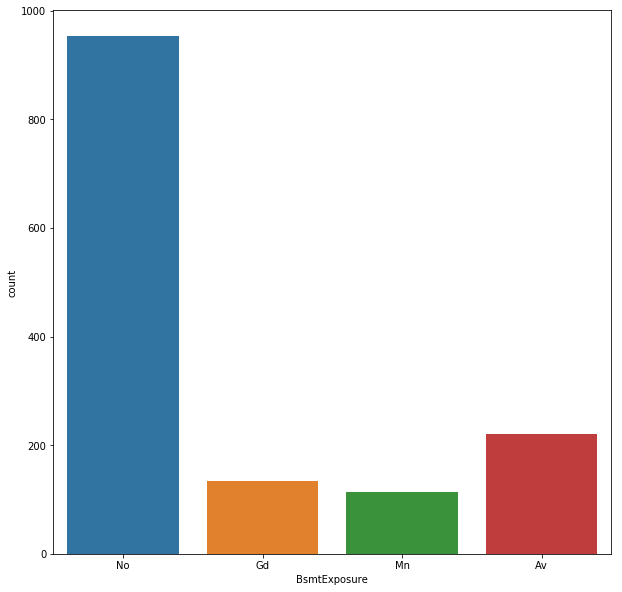

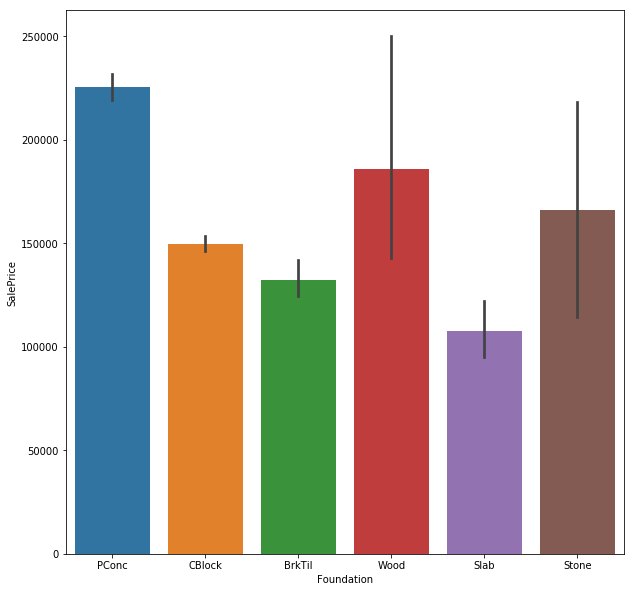

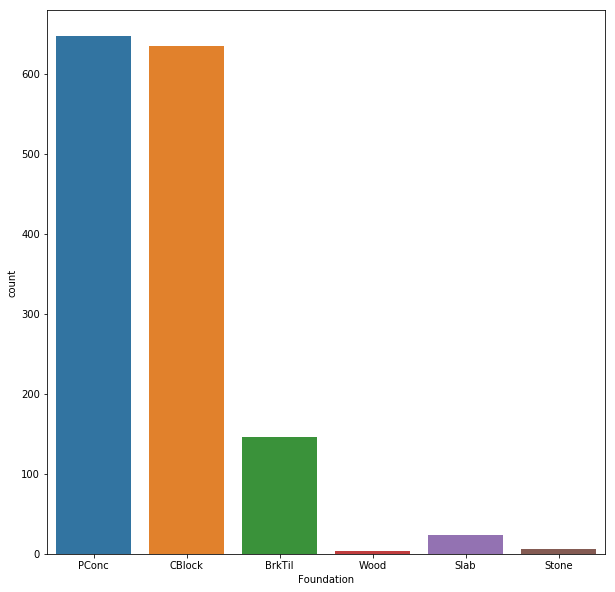

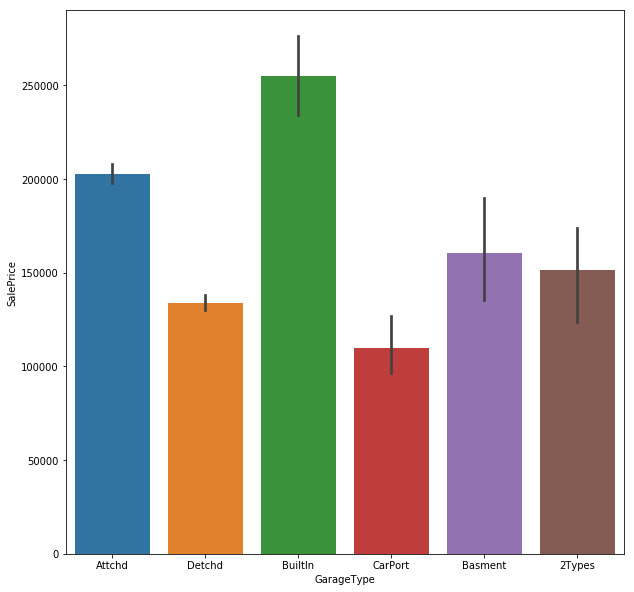

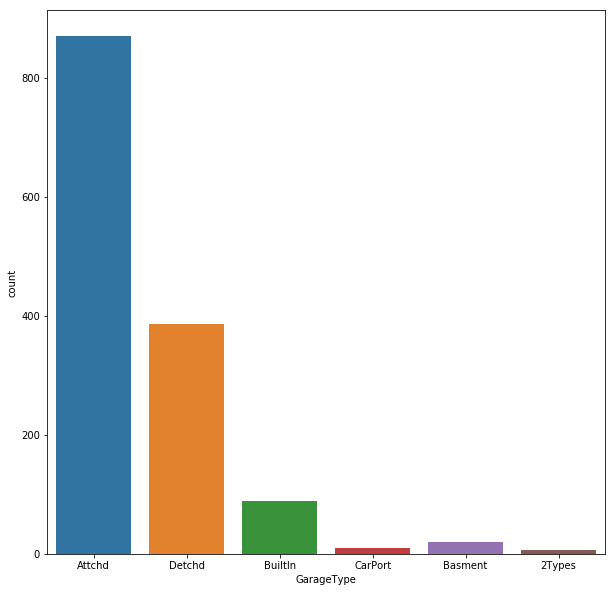

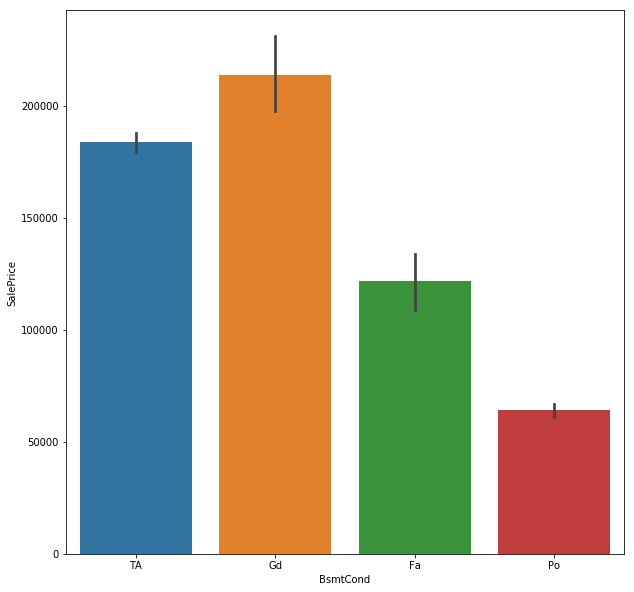

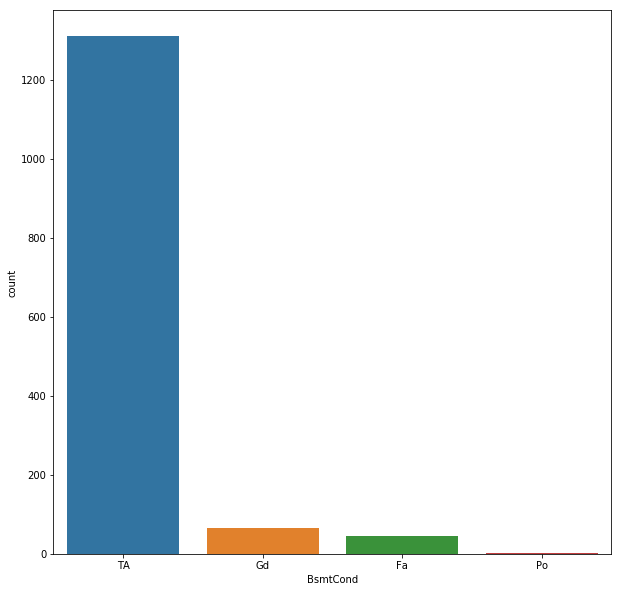

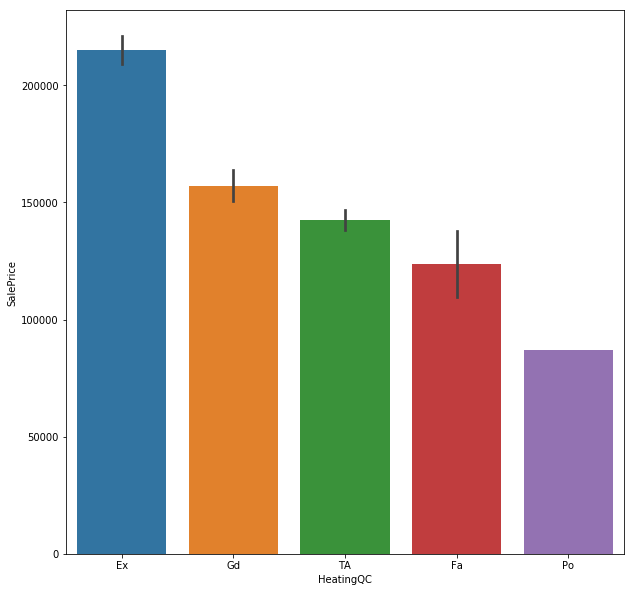

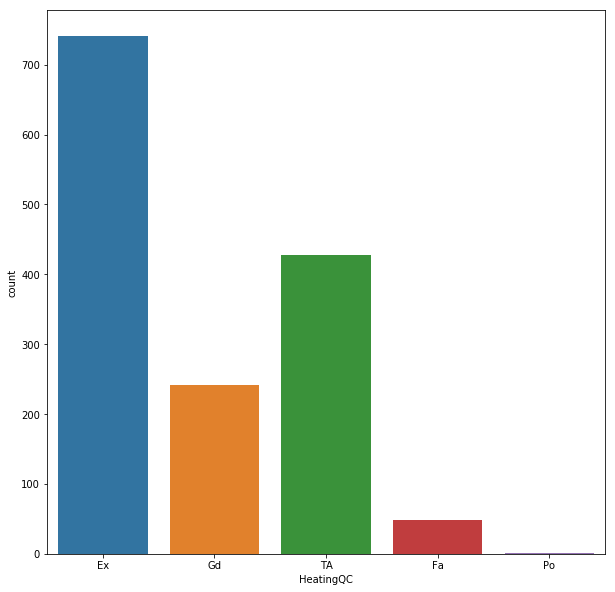

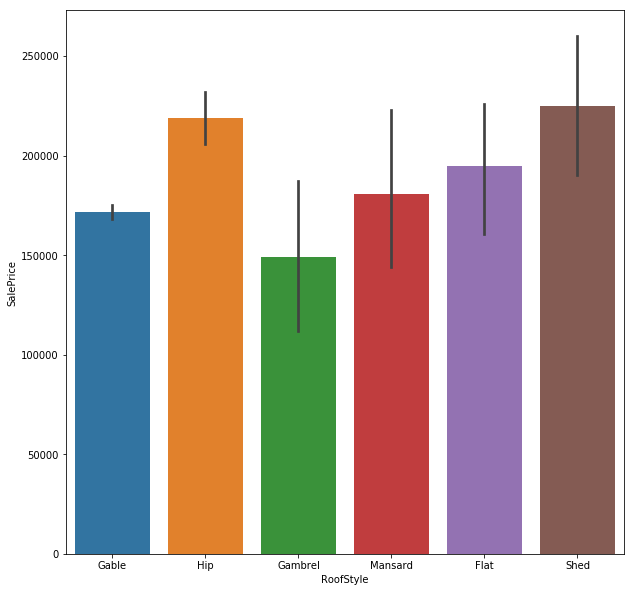

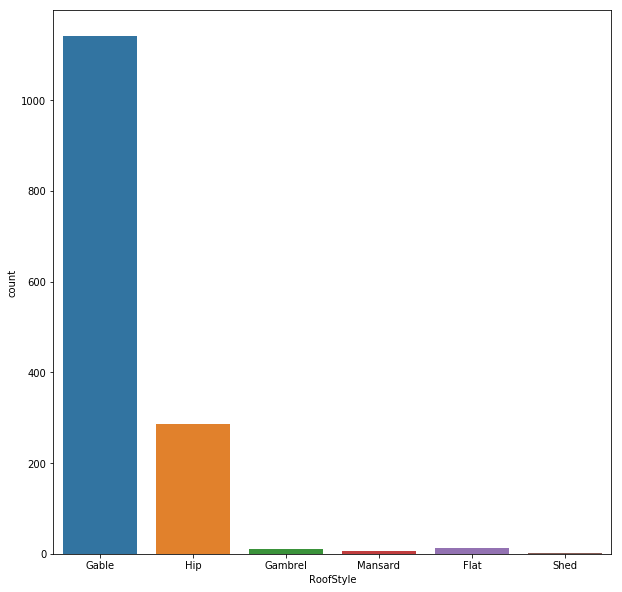

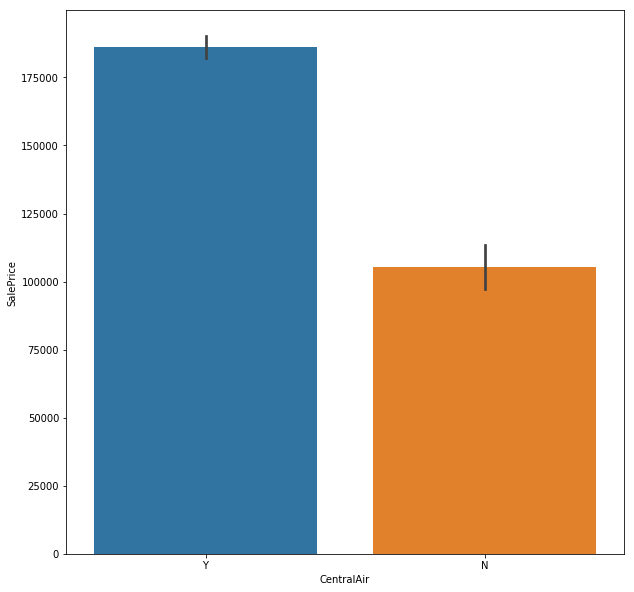

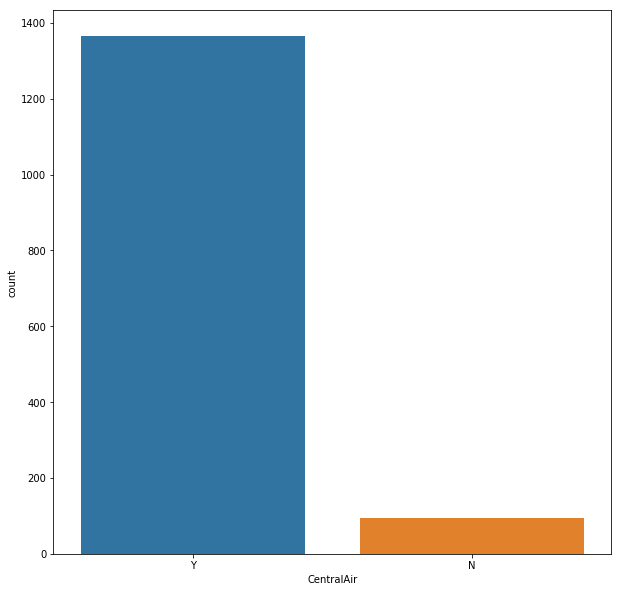

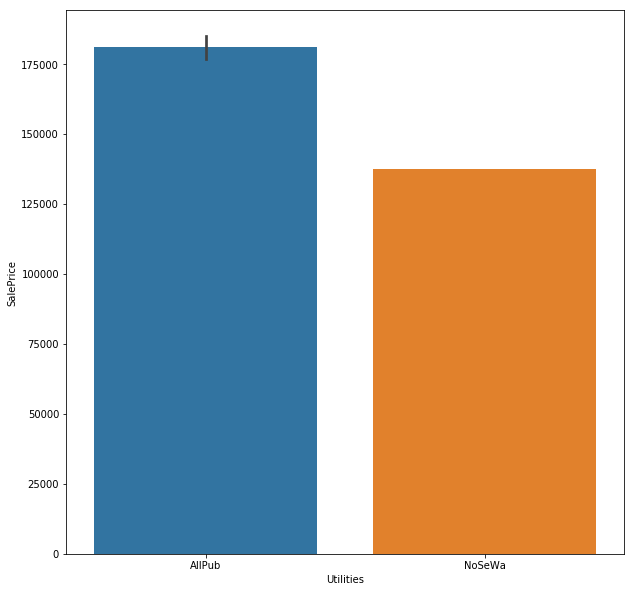

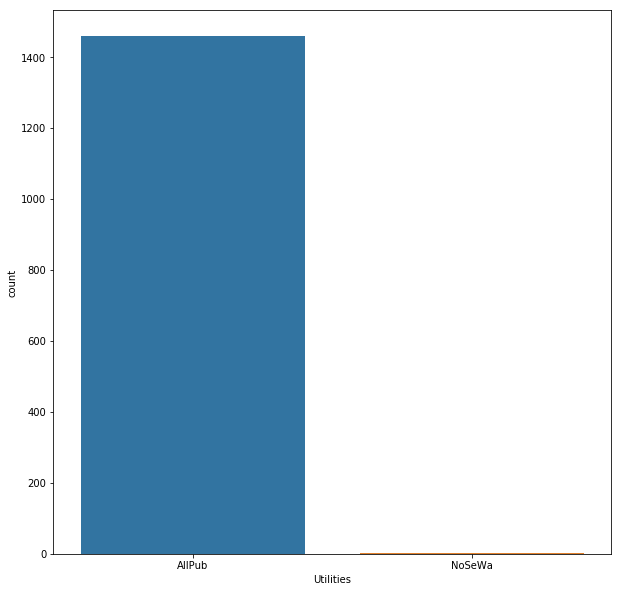

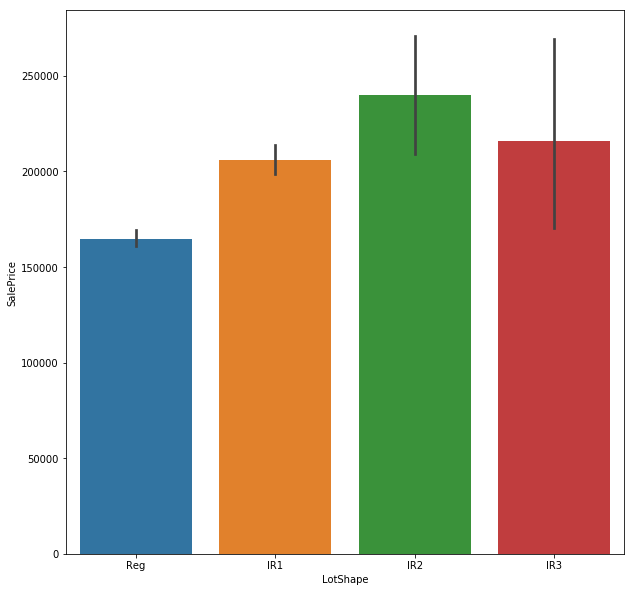

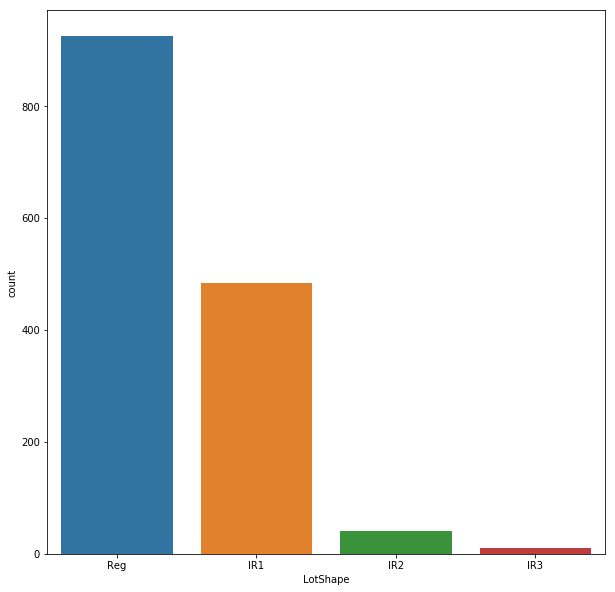

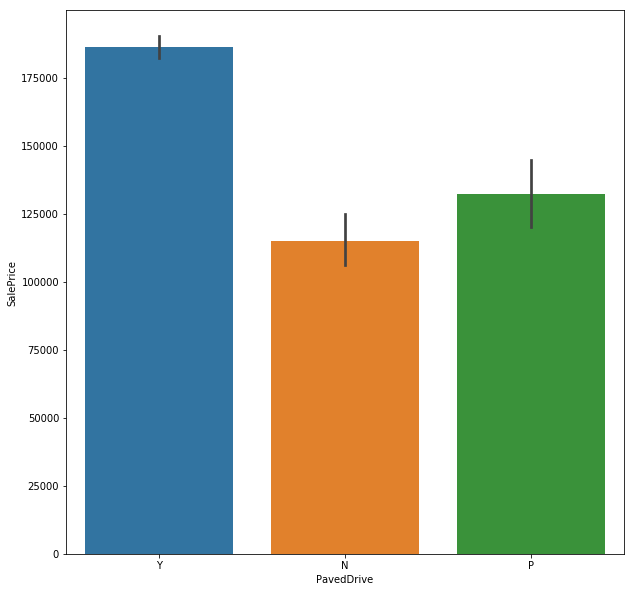

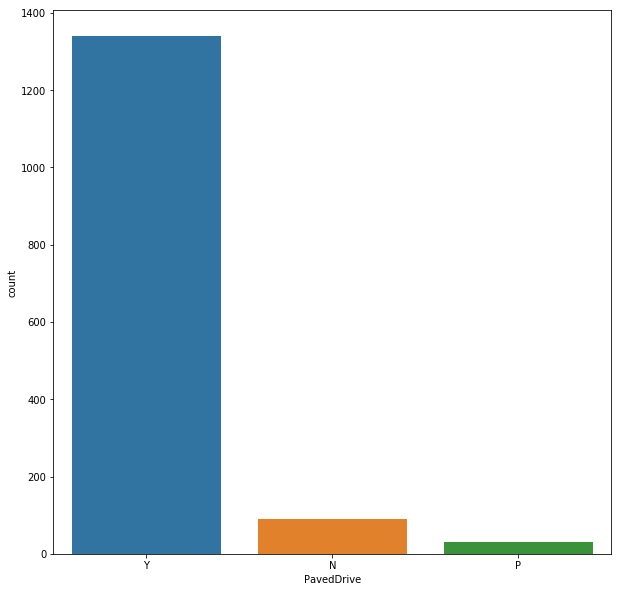

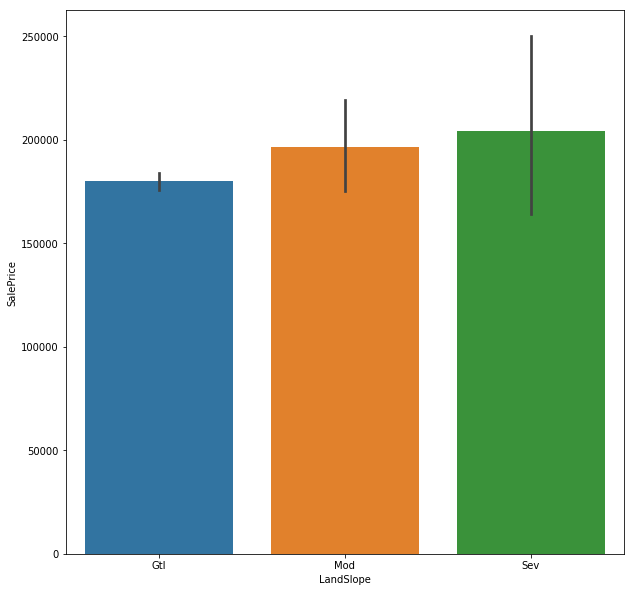

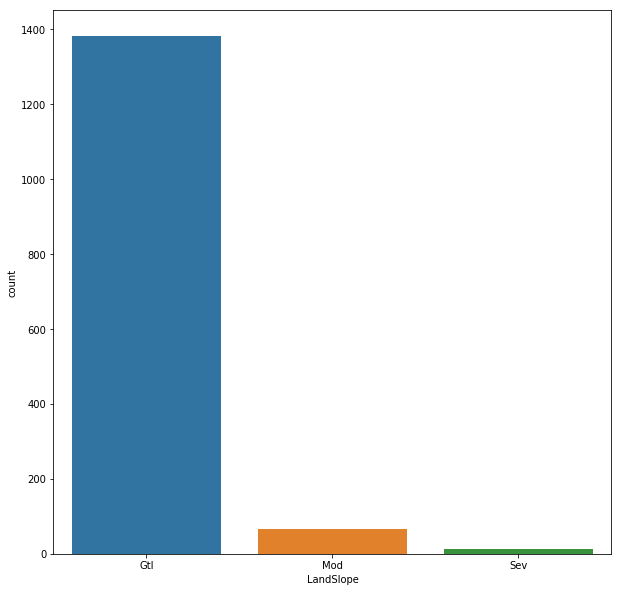

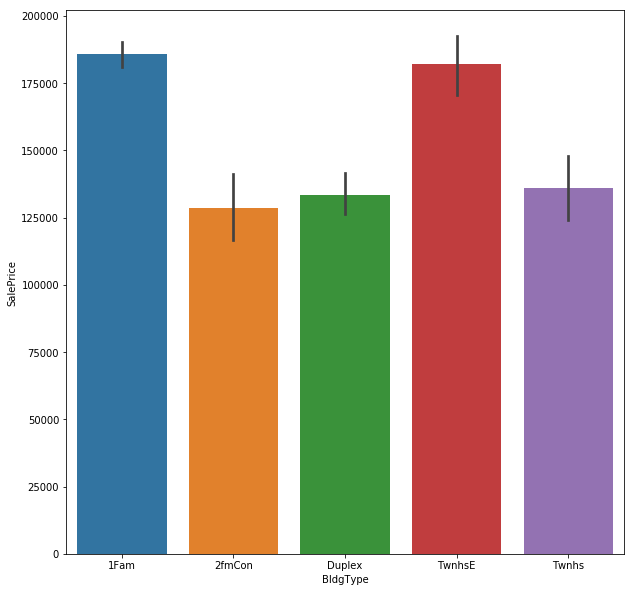

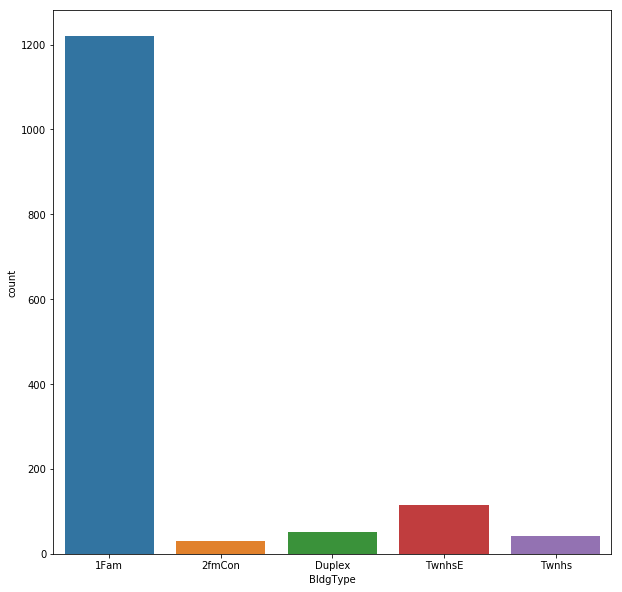

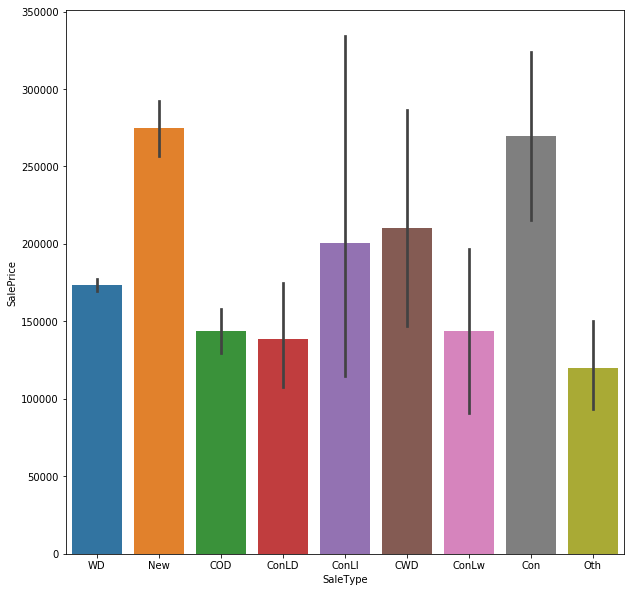

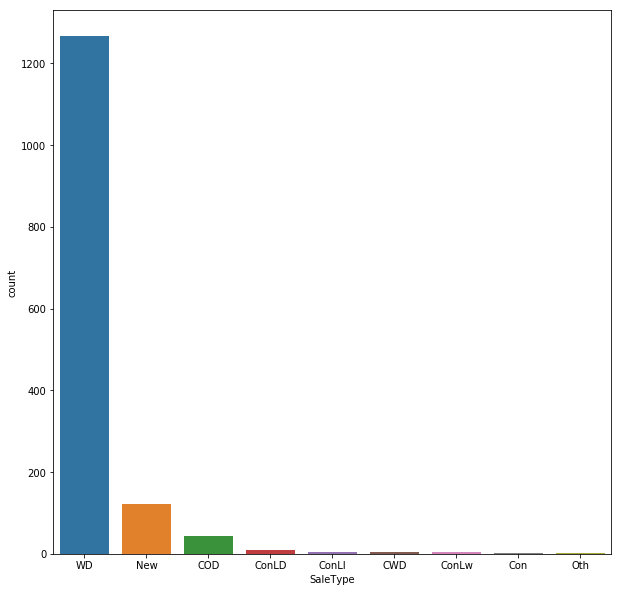

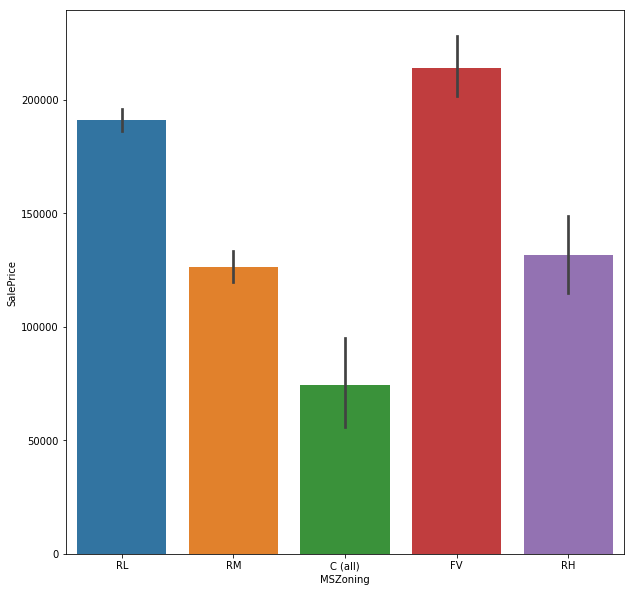

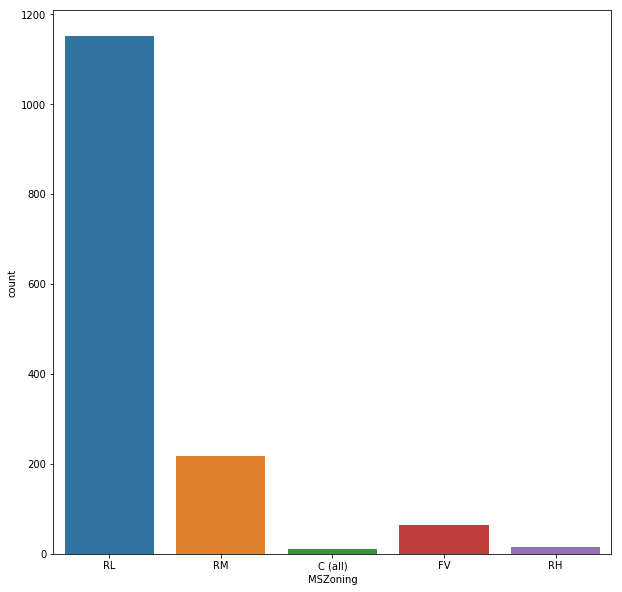

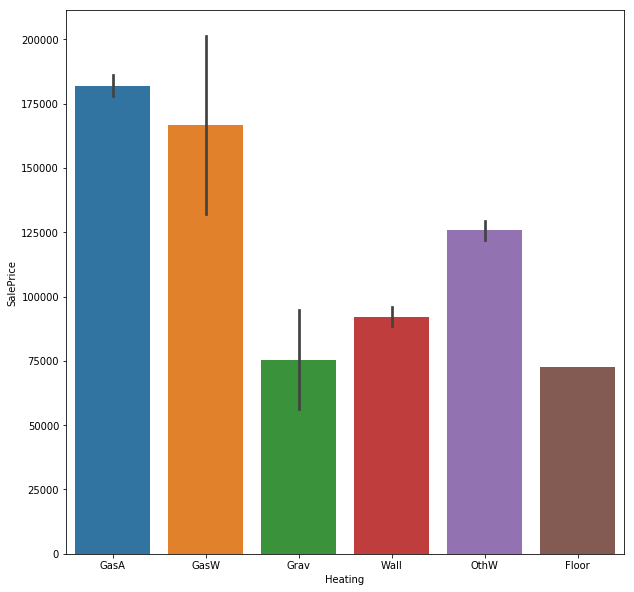

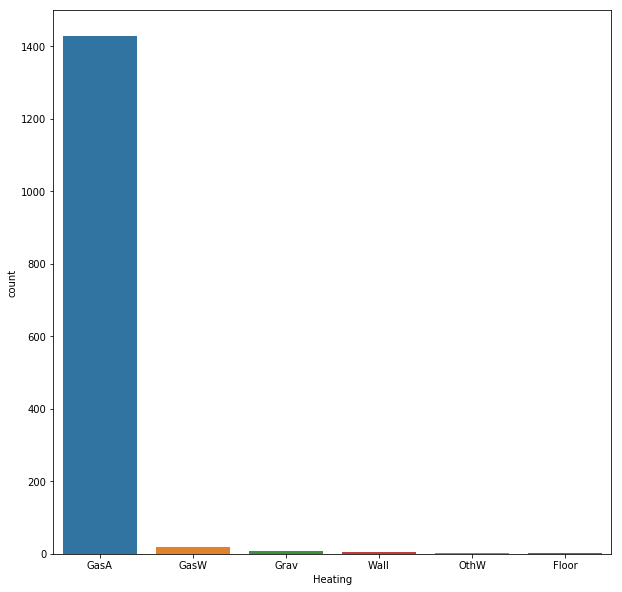

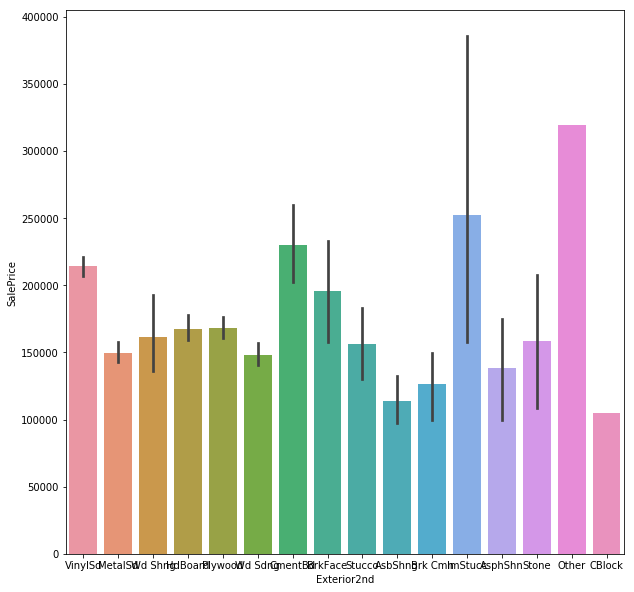

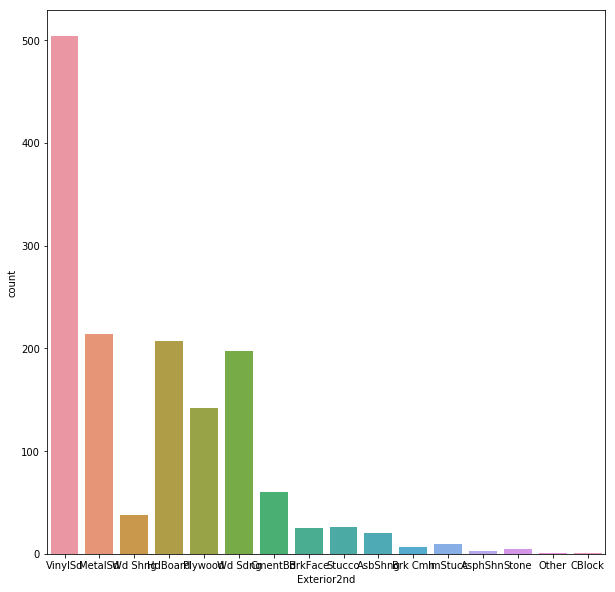

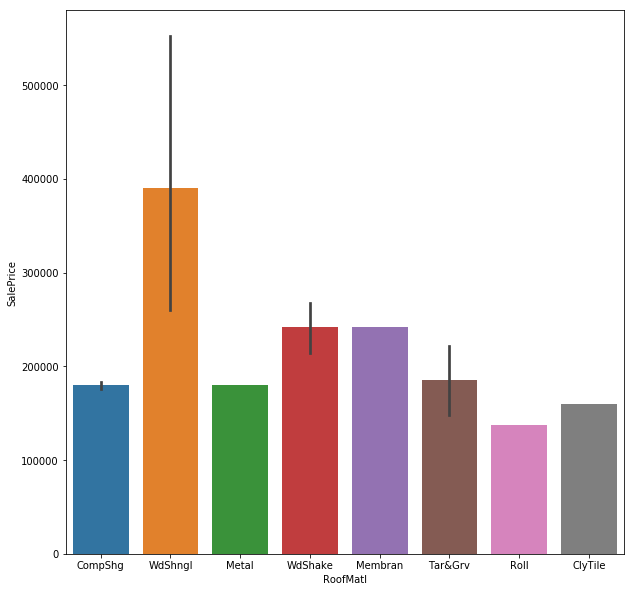

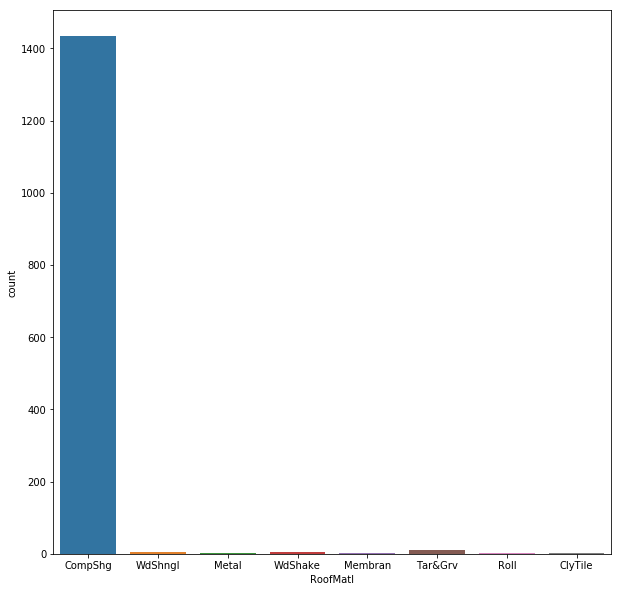

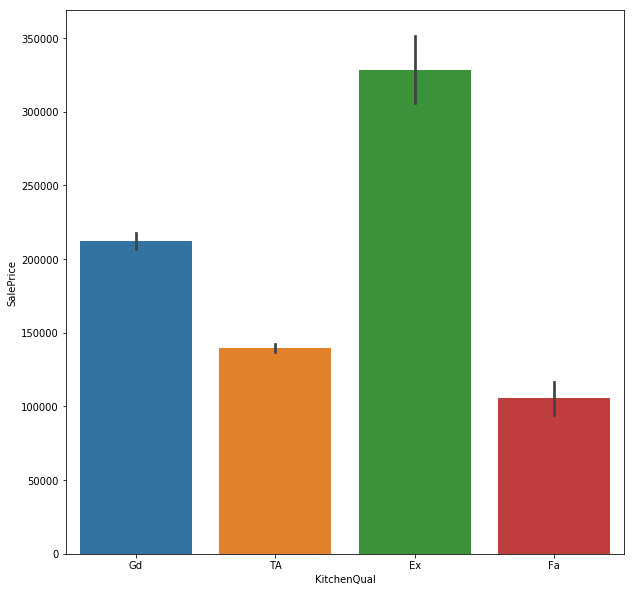

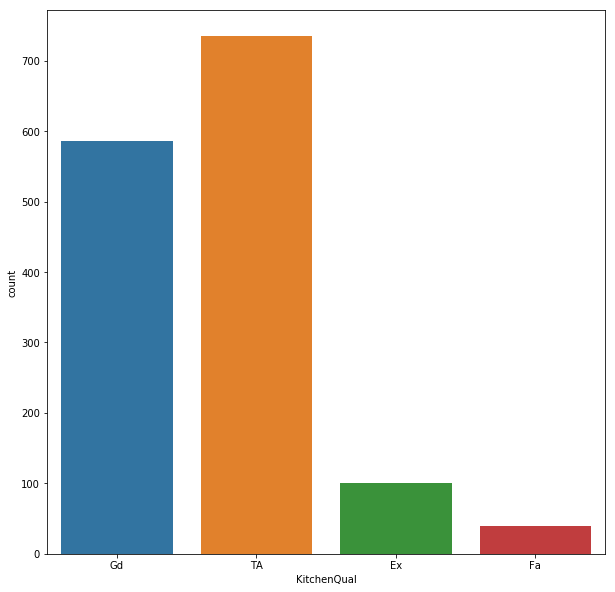

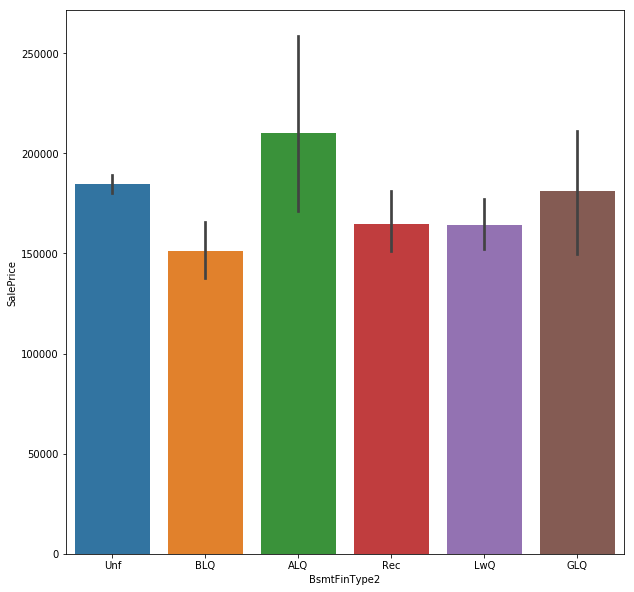

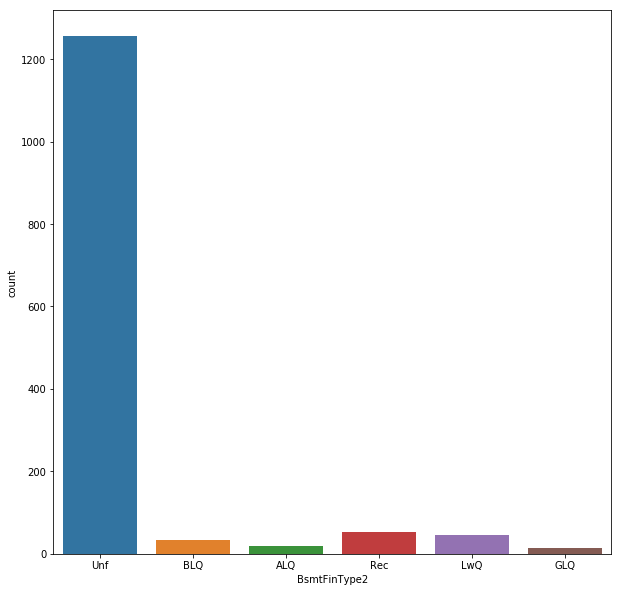

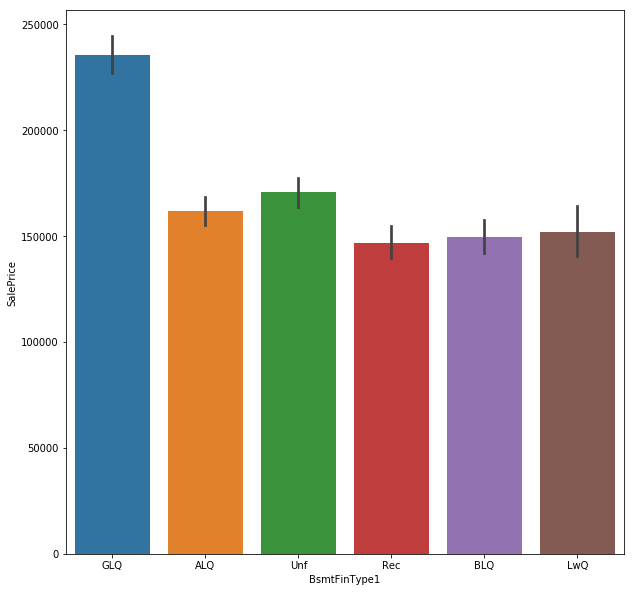

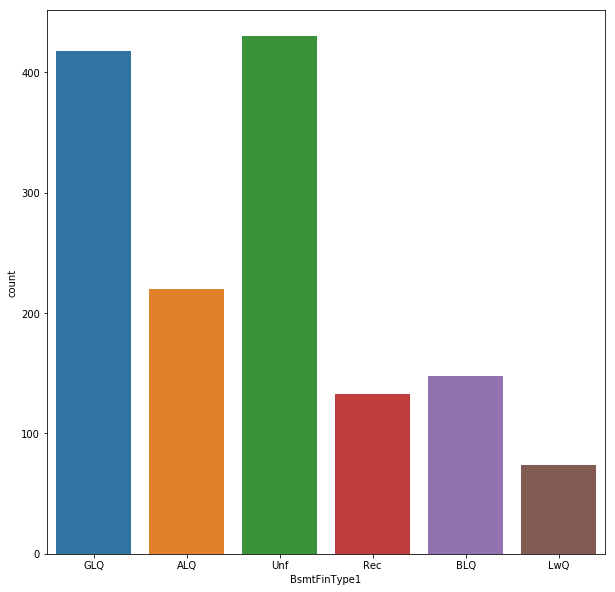

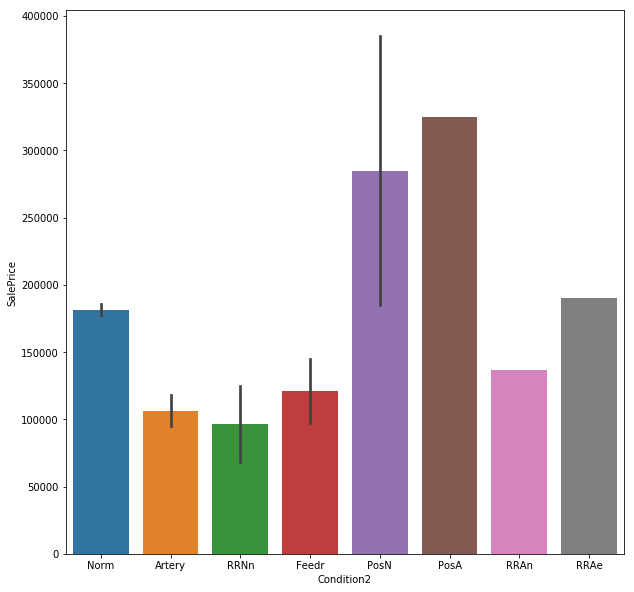

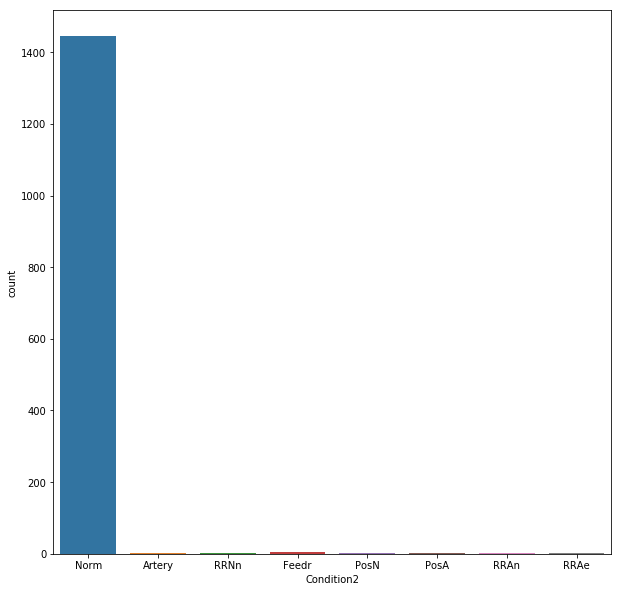

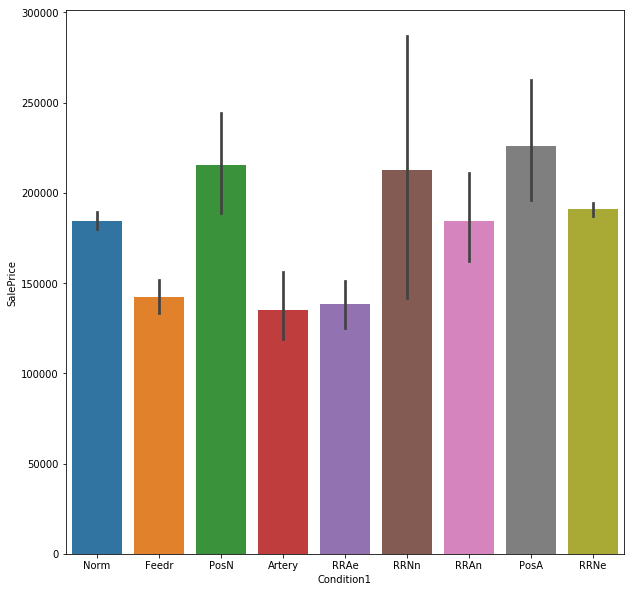

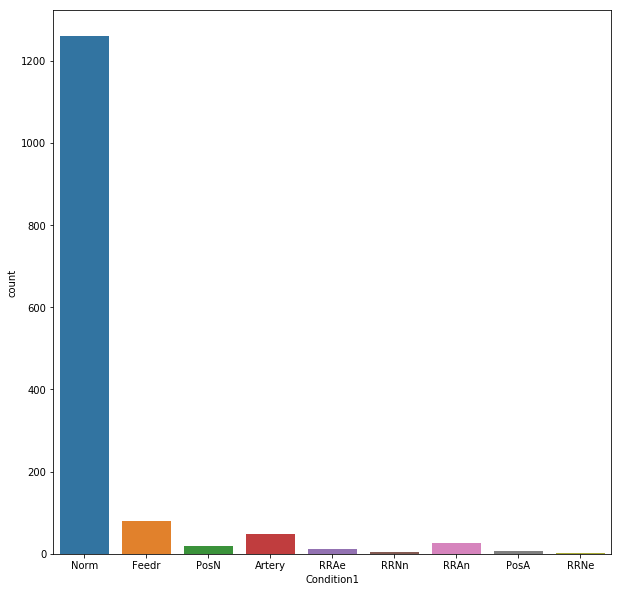

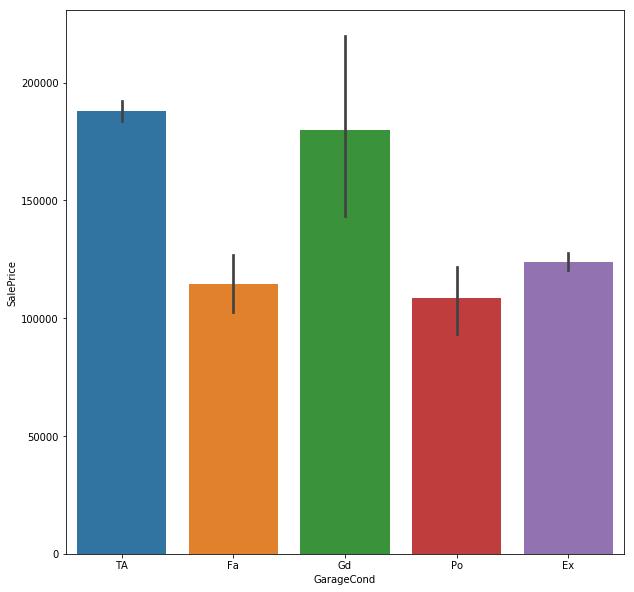

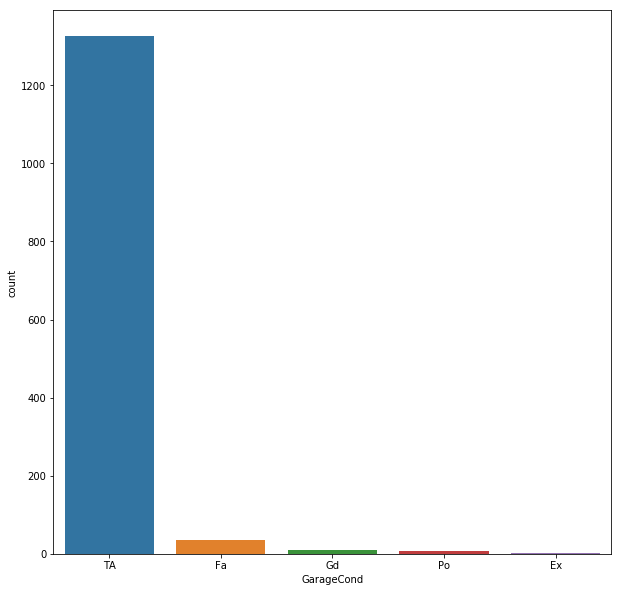

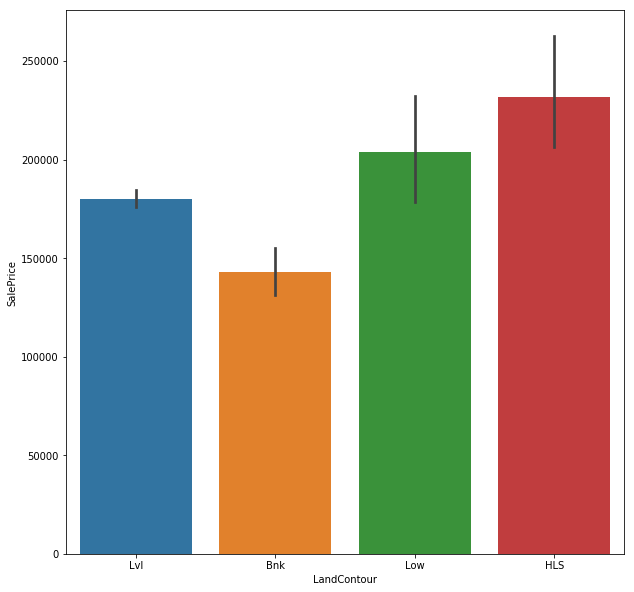

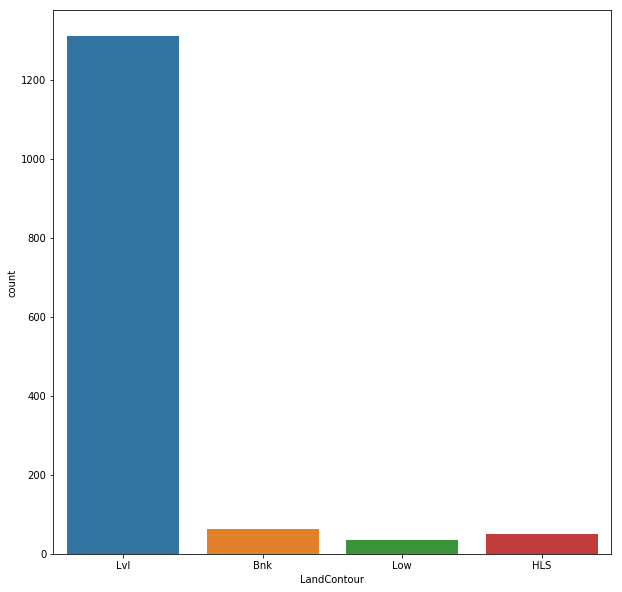

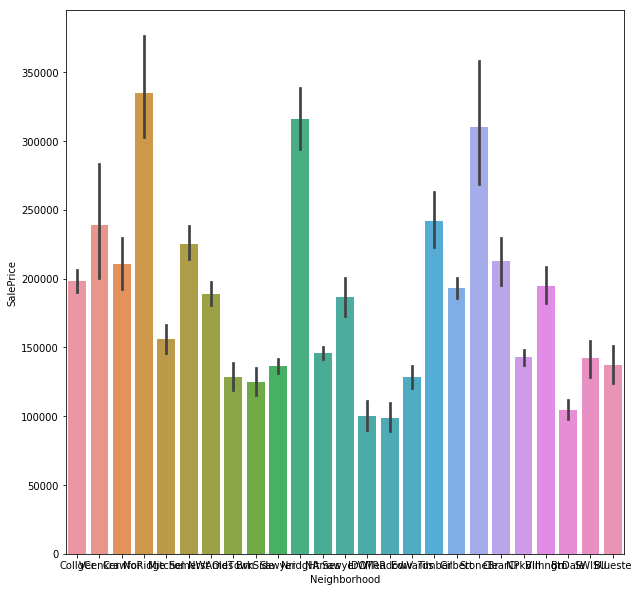

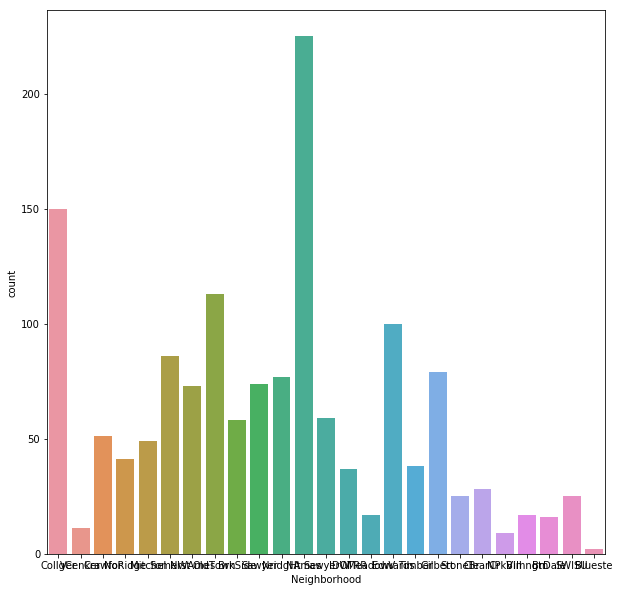

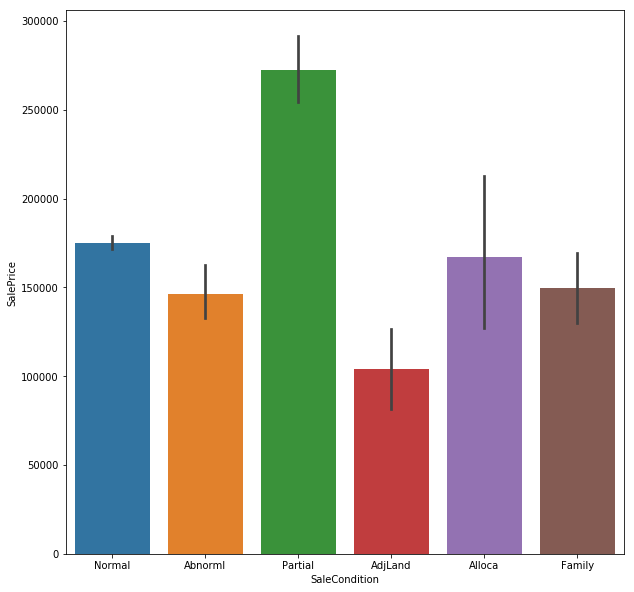

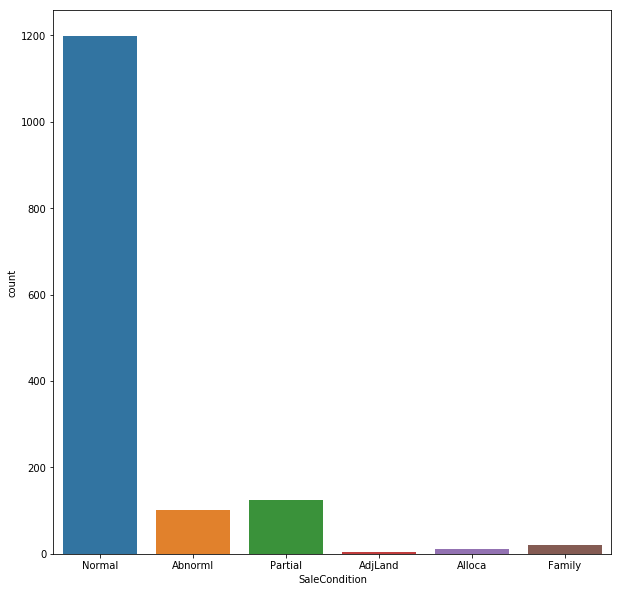

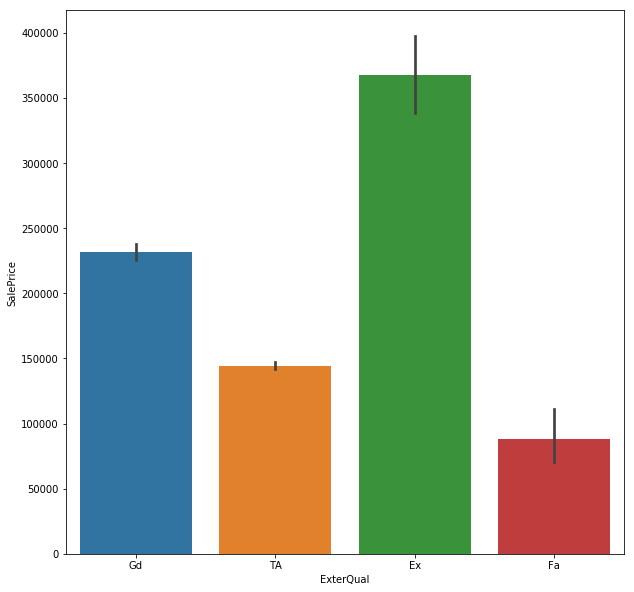

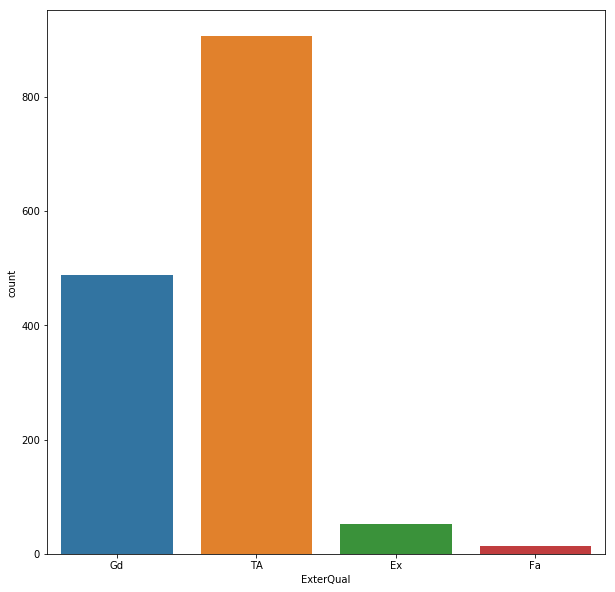

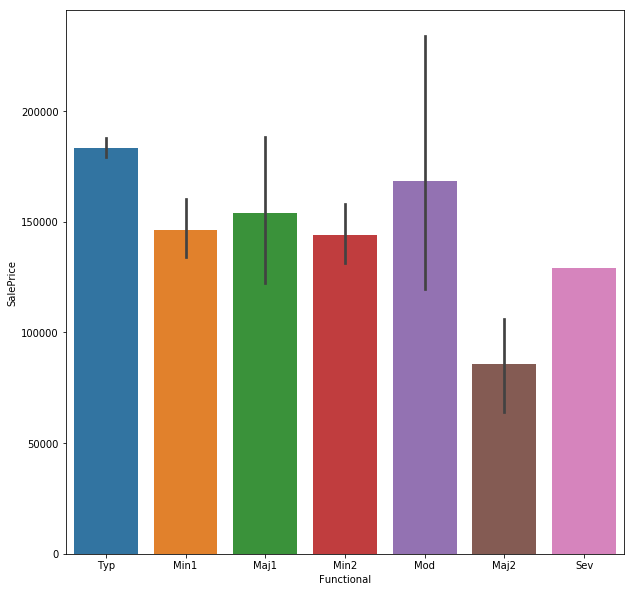

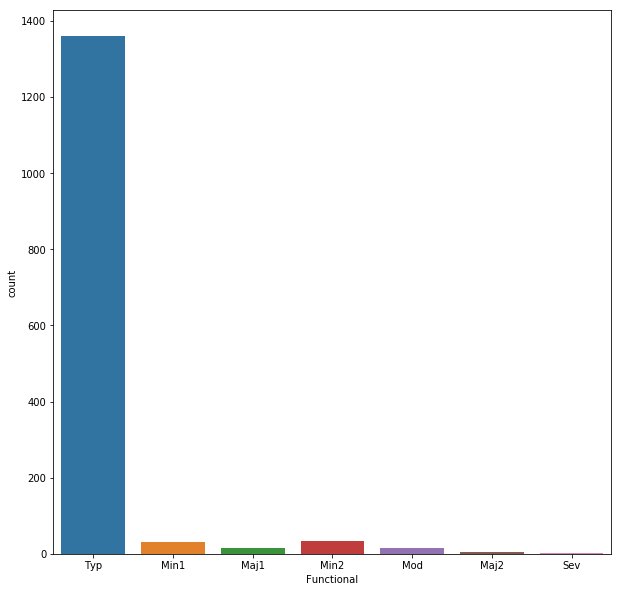

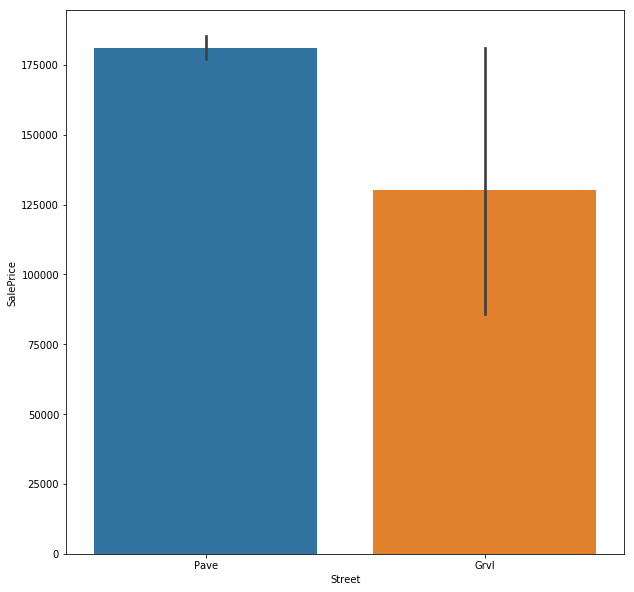

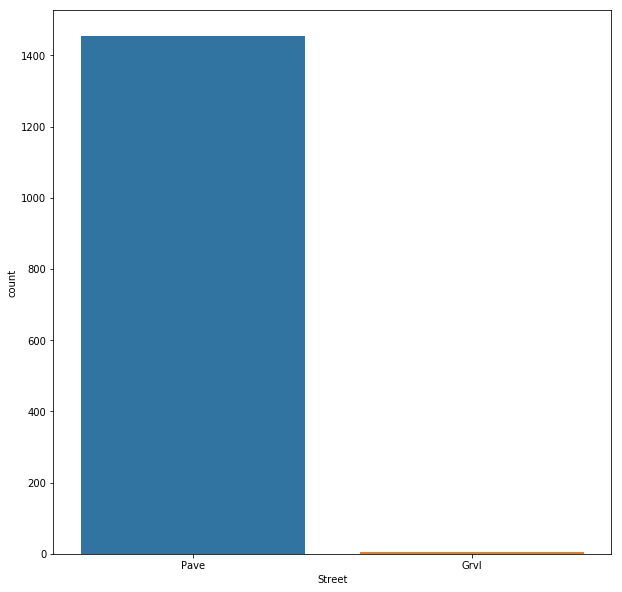

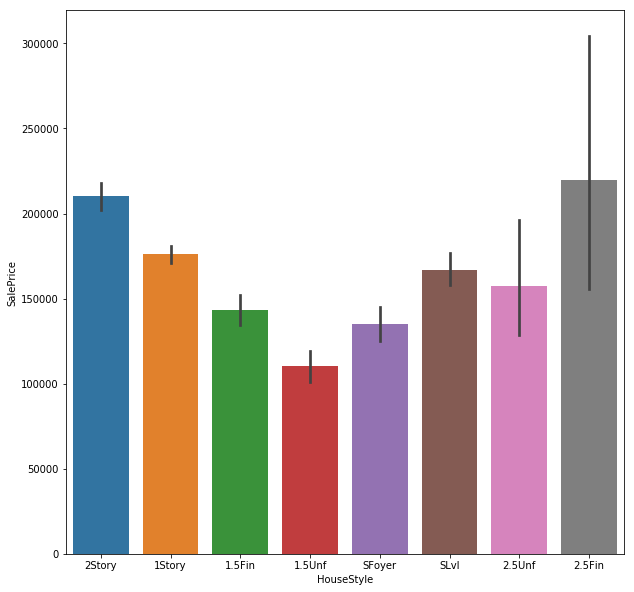

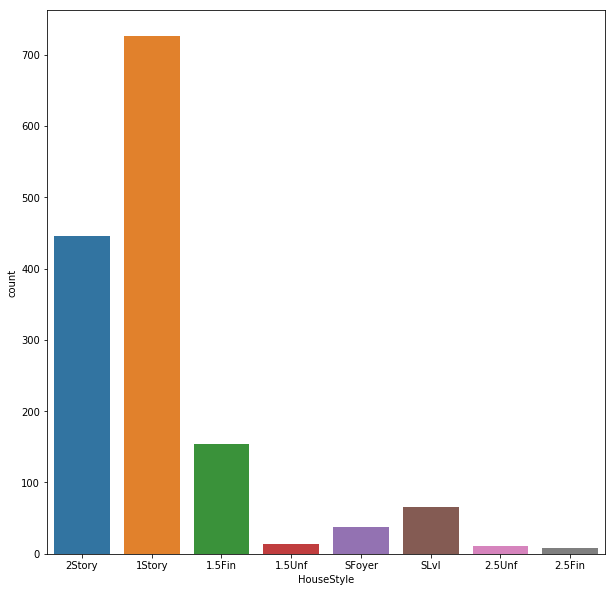

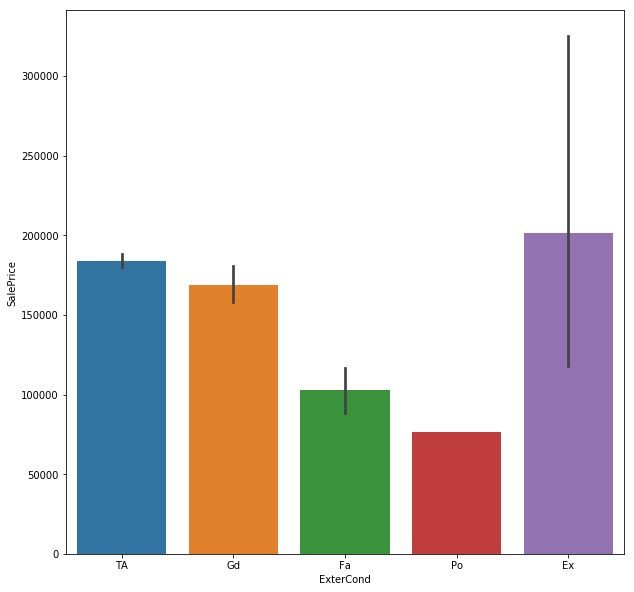

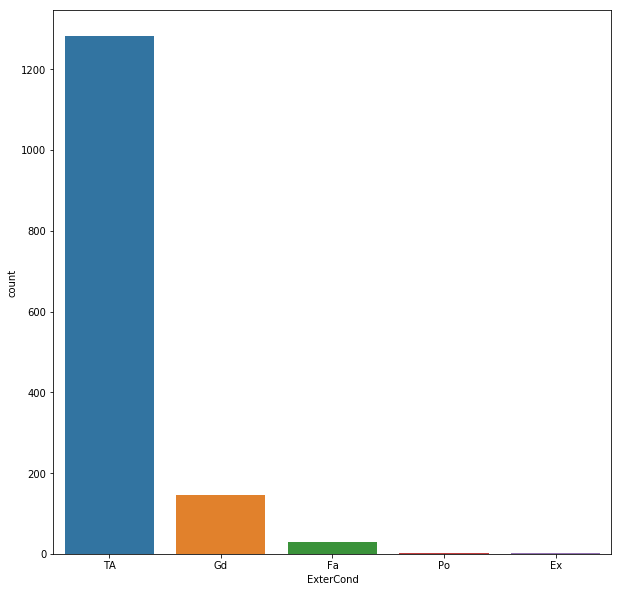

In [12]:
for i in categorical_columns:
    plot_things(i)

## Categorical droped features:
- SZoning
- LotFrontage
- Utilities
- Exterior1st
- Exterior2nd
- MasVnrType
- MasVnrArea
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- BsmtHalfBath
- BsmtFullBath
- KitchenQual
- Functional
- GarageType
- GarageYrBlt
- GarageFinish
- GarageCars
- GarageArea
- GarageQual
- GarageCond
- SaleType

## Cleaning and transforming data:


- #### List of non included features for training and using the predictions

In [13]:
non_included_categorical=["LotConfig","GarageQual","Electrical","BsmtCond","CentralAir","Utilities","PavedDrive","LandSlope","BldgType","SaleType","Heating","RoofMatl","BsmtFinType2","Condition2","Condition1","GarageCond","LandContour","Functional","Street"]
non_included=list(numerical_feaures_noincluded)
non_included.extend(non_included_categorical)
non_included.extend(["MiscFeature","Fence","PoolQC","FireplaceQu","Alley"])
not_included_train=list(non_included)
non_included_test=list(non_included)
not_included_train.append("SalePrice")


- #### Calling the LabelEncoder to transform after the categorical data into numerical

In [14]:
le=LabelEncoder()


- ### Adding missing values (mean for numerical and mode for categorical)
- ### Transforming categorical data to numerical one

In [17]:
def clean(train,test,drop_features_train,drop_features_test):
    all_data=pd.concat([train.drop(drop_features_train,axis=1),test.drop(drop_features_test,axis=1)])
    columns_with_nan=all_data.columns[all_data.isnull().any()].tolist()
    num_cols=list(all_data._get_numeric_data().columns)
    for i in columns_with_nan:
        feature=i.strip('"\'')
        if (i in num_cols):
            feature=i.strip('"\'')
            #print feature
            all_data.loc[getattr(all_data,feature).isnull(),(i)]=np.nanmean(train[i])
        else:
            all_data.loc[getattr(train,feature).isnull(),(i)]=getattr(train,feature).mode()[0]
    
    for i in list(all_data.columns.values):
        if i in num_cols:
            continue
        else:
            all_data[i]=le.fit_transform(all_data[i])
            #print feature
            
        
    return all_data[:len(train)],all_data[len(train):]

- #### Prepare the actual data

In [18]:
data_train,data_test=clean(train,test,not_included_train,non_included_test)

- ####  Check that aren't missing values

In [19]:
data_test.isnull().sum()

MSZoning         0
LotFrontage      0
LotArea          0
LotShape         0
Neighborhood     0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
ScreenPorch      0
PoolArea         0
SaleCondition    0
dtype: int64

In [20]:
data_train.isnull().sum()

MSZoning         0
LotFrontage      0
LotArea          0
LotShape         0
Neighborhood     0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
ScreenPorch      0
PoolArea         0
SaleCondition    0
dtype: int64

- #### Normilize the train and test data

In [22]:
from sklearn.preprocessing import StandardScaler
standar_scaler=StandardScaler()
X_train=standar_scaler.fit_transform(data_train)
X_test=standar_scaler.fit_transform(data_test)


- #### Prepare Price target for the training set
- #### Checking that are all the SalePrice for all the train data

In [24]:
y_train=train['SalePrice']
y_train.isnull().sum()

0

## Prepare the Linear regression model

In [25]:
#from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import GridSearchCV

In [26]:
lr=LinearRegression()

- ### Training

In [27]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- #### Prediction

In [28]:
prediction_price=lr.predict(X_test)

- #### Submission

In [29]:
submission=pd.DataFrame({"Id":test['Id'],"SalePrice":prediction_price})

In [30]:
submission.to_csv('second_try.csv',index=False)

In [31]:
lr.score(X_train,y_train)

0.83026168006250578